In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [2]:
us_states = "data/map_data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
IN_basemap = gpd.read_file(us_states,crs=4326)
IN_basemap = IN_basemap[IN_basemap['NAME']=="Indiana"]
IN_basemap = IN_basemap.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters
IN_basemap

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
53,18,00448508,0400000US18,18,IN,Indiana,00,92789302676,1538002829,"POLYGON ((-9806997.783 4565876.763, -9806632.2..."


In [3]:
IN_geo = IN_basemap['geometry']

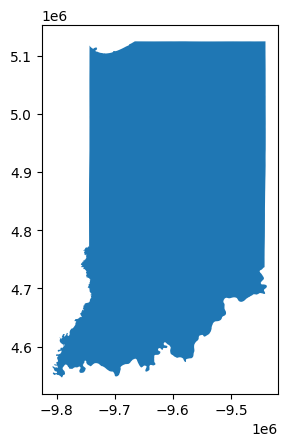

In [4]:
IN_basemap.plot();

In [5]:
# this is wind data for the entire world, need to sort to only the coords within IN
folder = "data/wind_data/"
files = ["uwnd.10m.gauss.2022.nc","vwnd.10m.gauss.2022.nc"]
uraw = nc.Dataset(folder+files[0])
vraw = nc.Dataset(folder+files[1])

In [6]:
lat = np.ma.getdata(uraw['lat'],False)
lon = np.ma.getdata(uraw['lon'],False)

In [7]:
# data format is time, blank, latitude(y), longitude(x)
uwnd = np.array(np.ma.getdata(uraw['uwnd'],False)[:,0,:,:],dtype=float)
vwnd = np.array(np.ma.getdata(vraw['vwnd'],False)[:,0,:,:],dtype=float)

In [8]:
# averaged wind speeds (365 days avg combined to 1 value)
uavg = np.average(uwnd,0) # 94x192
vavg = np.average(vwnd,0) # 94x192
wind_mag = np.hypot(uavg,vavg)
wind_dir = np.rad2deg(np.arctan2(vavg,uavg))

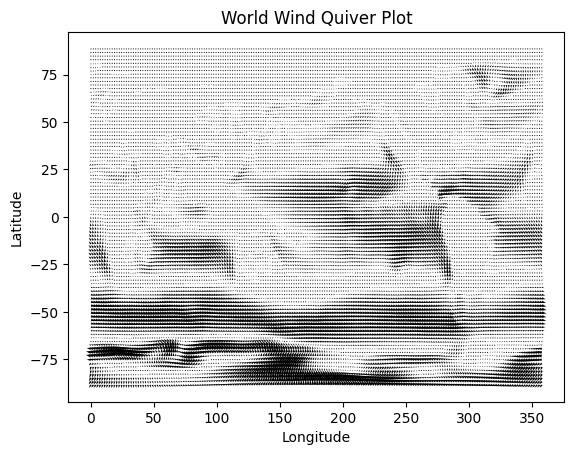

In [9]:
x,y = np.meshgrid(lon,lat) # x varies along columns, y varies along rows 
plt.quiver(x,y,uavg,vavg) # uavg, vavg, x, y, all have shapes 94x192
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('World Wind Quiver Plot');

In [10]:
wind_df = pd.DataFrame(data={'mag':wind_mag.flatten(),'dir':wind_dir.flatten()})

# WGS84 (EPSG: 4326), Universal geographic coordinate system (latitude and longitude)
wind_geo = GeoDataFrame(wind_df,geometry = [Point(xy) for xy in zip(x.flatten(),y.flatten())],crs=4326)
wind_geo = wind_geo.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters

In [11]:
wind_x = wind_geo['geometry'].x
wind_y = wind_geo['geometry'].y
IN_maxx = float(IN_geo.bounds.maxx)
IN_minx = float(IN_geo.bounds.minx)
IN_maxy = float(IN_geo.bounds.maxy)
IN_miny = float(IN_geo.bounds.miny)

IN_wind = wind_geo[(wind_x<=IN_maxx) & (wind_x>=IN_minx) & (wind_y<=IN_maxy) & (wind_y>=IN_miny)]

<Axes: >

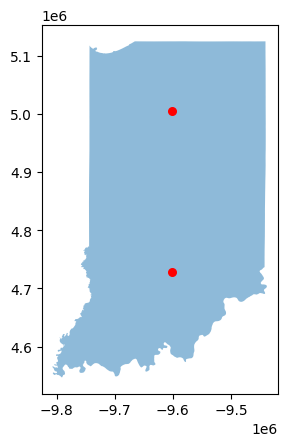

In [12]:
fig, ax = plt.subplots(1,1)
#fig.set_size_inches(10,8.5)
IN_basemap.plot(ax=ax,alpha=0.5)
IN_wind.plot(ax=ax,color='red',markersize=30)

In [13]:
IN_wind

,mag,dir,geometry
4946,1.818036,42.588122,POINT (-9601306.081 5005219.783)
5138,1.599860,46.333946,POINT (-9601306.081 4728406.284)


In [85]:
uraw.__dict__


{'Conventions': 'CF-1.0',
 'title': 'mean Daily NCEP/DOE Reanalysis 2',
 'comments': 'Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)\n(4x/day).  Data interpolated from model (sigma) surfaces to gaussian grid.',
 'platform': 'Model',
 'source': 'NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model',
 'institution': 'National Centers for Environmental Prediction',
 'dataset_title': 'NCEP-DOE AMIP-II Reanalysis',
 'References': 'https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html',
 'source_url': 'http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/',
 'history': 'created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, deflated non-packed NetCDF4 2020/05'}

In [186]:
IN_basemap = gpd.read_file(us_states,crs=4326)
IN_basemap = IN_basemap[IN_basemap['NAME']=="Indiana"]
IN_basemap.bounds

,minx,miny,maxx,maxy
53,-88.097892,37.771742,-84.784579,41.760592


In [99]:
od_files=["data_2016.csv"]#,"data_2017.csv","data_2018.csv","data_2019.csv"]
years = [name.split(".csv")[0].split("_")[1] for name in od_files]

od_dfs = []
for yr in years:
    df = gpd.read_file("data/saved_odDFs/Dataframe_OD_"+str(yr)+".shp")
    df = df.set_index('county')
    od_dfs.append(df)